# Topic Tagging

 Run | Accuracy
-----|---------
ULMFiT-CE-Spacy | 0.94 


In [ ]:
# !pip install light-the-torch
# !ltt install torch torchvision
!pip install -Uq fastai==2.1.4 fastcore==1.3.2 nbdev

In [ ]:
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [ ]:
# Load projects
url = "https://raw.githubusercontent.com/madewithml/datasets/main/projects.json"
projects = json.loads(urlopen(url).read())
print (json.dumps(projects[-305], indent=2))

{
  "id": 324,
  "title": "AdverTorch",
  "description": "A Toolbox for Adversarial Robustness Research",
  "tags": [
    "code",
    "library",
    "security",
    "adversarial-learning",
    "adversarial-attacks",
    "adversarial-perturbations"
  ]
}


In [ ]:
# Load tags
url = "https://raw.githubusercontent.com/madewithml/datasets/main/tags.json"
tags_dict = OrderedDict(json.loads(urlopen(url).read()))
print (f"{len(tags_dict)} tags")

400 tags


In [ ]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag='question-answering'):
    print (json.dumps(tags_dict[tag], indent=2))

interactive(children=(Dropdown(description='tag', index=283, options=('3d', 'action-localization', 'action-rec…

In [ ]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

2032 projects


,id,title,description,tags
0,2438,How to Deal with Files in Google Colab: What Y...,How to supercharge your Google Colab experienc...,"[article, google-colab, colab, file-system]"
1,2437,Rasoee,A powerful web and mobile application that ide...,"[api, article, code, dataset, paper, research,..."
2,2436,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,"[article, deep-learning, machine-learning, dim..."
3,2435,Top “Applied Data Science” Papers from ECML-PK...,Explore the innovative world of Machine Learni...,"[article, deep-learning, machine-learning, adv..."
4,2434,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,"[article, code, pytorch, library, 3d, computer..."


In [ ]:
len(df)

2032

In [ ]:
df['label'] =  df.tags.apply(lambda x: ','.join(x))

In [ ]:
df.head()

,id,title,description,tags,label
0,2438,How to Deal with Files in Google Colab: What Y...,How to supercharge your Google Colab experienc...,"[article, google-colab, colab, file-system]","article,google-colab,colab,file-system"
1,2437,Rasoee,A powerful web and mobile application that ide...,"[api, article, code, dataset, paper, research,...","api,article,code,dataset,paper,research,django..."
2,2436,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,"[article, deep-learning, machine-learning, dim...","article,deep-learning,machine-learning,dimensi..."
3,2435,Top “Applied Data Science” Papers from ECML-PK...,Explore the innovative world of Machine Learni...,"[article, deep-learning, machine-learning, adv...","article,deep-learning,machine-learning,adverti..."
4,2434,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,"[article, code, pytorch, library, 3d, computer...","article,code,pytorch,library,3d,computer-visio..."


In [ ]:
# Input
df['text'] = df.title + " " + df.description

In [ ]:
def filter(l, include=[], exclude=[]):
    """Filter a list using inclusion and exclusion lists of items."""
    filtered = [item for item in l if item in include and item not in exclude]
    return filtered

In [ ]:
# Inclusion/exclusion criteria for tags
include = list(tags_dict.keys())
exclude = ['machine-learning', 'deep-learning',  'data-science',
           'neural-networks', 'python', 'r', 'visualization',
           'natural-language-processing', 'computer-vision']

In [ ]:
# Filter tags for each project
df.tags = df.tags.apply(filter, include=include, exclude=exclude)
tags = Counter(itertools.chain.from_iterable(df.tags.values))

In [ ]:
@widgets.interact(min_tag_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_tag_freq=30):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_tag_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_tag_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(5))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-5:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(5))

interactive(children=(IntSlider(value=30, description='min_tag_freq', max=258), Output()), _dom_classes=('widg…

In [ ]:
# Filter tags that have fewer than <min_tag_freq> occurances
min_tag_freq = 30
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if tags[tag] >= min_tag_freq)
df.tags = df.tags.apply(filter, include=list(tags_above_freq.keys()))

In [ ]:
# Remove projects with no more remaining relevant tags
df = df[df.tags.map(len) > 0]
print (f"{len(df)} projects")

1239 projects


In [ ]:
import fastai, fastcore, torch 
fastai.__version__, fastcore.__version__, torch.__version__

('2.1.4', '1.3.2', '1.7.0+cu101')

In [ ]:
from fastai.text.all import *

In [ ]:
dls = TextDataLoaders.from_df(df, valid_pct=0.1, seed=42, text_col='text', label_col='label', label_delim=',', y_block=MultiCategoryBlock)

KeyError: ignored

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, loss_func=LabelSmoothingCross, metrics=accuracy_multi)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.05754399299621582)

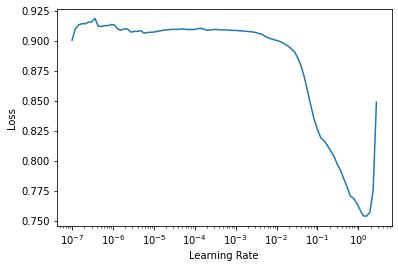

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 5e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.753315,0.208214,0.943197,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.267879,0.208163,0.943197,01:26
1,0.225678,0.192173,0.943197,01:26
2,0.202384,0.183145,0.943565,01:27


In [ ]:
preds, targets = learn.get_preds(ds_idx=1)

In [ ]:
accuracy_multi(preds, targets, thresh=0.9, sigmoid=False)

TensorText(0.9432)

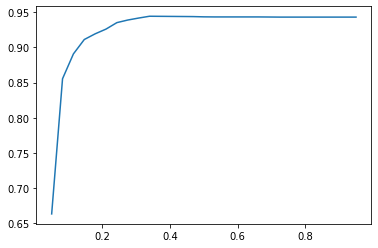

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targets, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Here we get the best accuracy score for any thresh > 0.4

## References

- fastai Chapter 6 on MultiLabeling https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb


